In [1]:
#standard library imports
import datetime
import itertools
import os
import random
import time
import warnings

#3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import nltk
from nltk.stem import PorterStemmer

#local app & library specific imports
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_recall_fscore_support #classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, random_split, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, BertConfig, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1060 6GB


In [3]:
import pandas as pd
from tqdm import tqdm
import os
import sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import classification_report as report
from sklearn.feature_extraction.text import CountVectorizer
import argparse
text = []
input_folder='./data/en/train-articles-subtask-1/others'
for fil in tqdm(filter(lambda x: x.endswith('.txt'), os.listdir(input_folder))):
    #print(input_folder+'/' +fil)
    iD, txt = fil[7:].split('.')[0], open(input_folder+'/' +fil, 'r', encoding='utf-8',errors='ignore').read() 
    text.append((iD, txt))

df_text = pd.DataFrame(text, columns=['id','text']).set_index('id')

75it [00:00, 29065.21it/s]


In [4]:
df_text

,text
id,
,NEW YORK (The Borowitz Report)A once-prominent...
,LAS VEGAS (The Borowitz Report)In what is bein...
,WASHINGTONEncouraging the group of visitors th...
,RALEIGH (The Borowitz Report)Delivering her cl...
,WASHINGTON (The Borowitz Report)Calling his ac...
...,...
t,WASHINGTONIn an effort to honor the sweet-ass ...
t,"AMES, IOWA (The Borowitz Report)Presidential c..."
,OTTAWA After sustained criticism over several...


In [5]:
train_df = pd.read_csv(
    "data/en/train_data_1.tsv",
    sep = "\t",
    header = 0,
    index_col = 0
)


langs=['en','it','fr','ge','po']#,'ru']
target_lang='en'
for i in langs:
    if i ==target_lang:
        train_df = pd.read_csv(
            "data/en/train_data_1.tsv",
            sep = "\t",
            header = 0,
            index_col = 0
        )
        print('Added en')
    else:
        train_df2 = pd.read_csv(
            'data/en/train_data_extra'+i+'.tsv',
            sep = "\t",
            header = 0,
            index_col = 0
        )
        print(i, 'Total:',len(train_df2))
        train_df=train_df.append(train_df2)
        print(len(train_df))


# Report the number of sentences.
print('Number of training articles: {:,}\n'.format(train_df.shape[0]))

Added en
it Total: 52
485
fr Total: 54
539
ge Total: 46
585
po Total: 40
625
Number of training articles: 625



/tmp/ipykernel_191816/2069905211.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df=train_df.append(train_df2)
/tmp/ipykernel_191816/2069905211.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df=train_df.append(train_df2)
/tmp/ipykernel_191816/2069905211.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df=train_df.append(train_df2)
/tmp/ipykernel_191816/2069905211.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df=train_df.append(train_df2)


In [6]:
train_df

,text,type
id,,
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire
832959523,How Theresa May Botched\n\nThose were the time...,satire
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire
833032367,Robert Mueller Not Recommending Any More Indic...,satire
814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire
...,...,...
25181,Side effects after Novavax vaccine against Cov...,reporting
25164,The Together party asks the government about t...,reporting
25187,President Andrzej Duda signed the Act on the c...,reporting


In [7]:
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
def clean_text(sentence):
    '''
        function to clean content column, make it ready for transformation and modeling
    '''
    sentence = sentence.lower()                #convert text to lower-case
    #sentence = re.sub('â€˜','',sentence)    # remove the text â€˜ which appears to occur flequently
    sentence = re.sub('[‘’“”…,":-;]', '', sentence) # remove punctuation
    sentence = re.sub('[()@.]', '', sentence)  #remove parentheses
    #sentence = re.sub("[^a-zA-Z]"," ",sentence) #remove numbers and keep text/alphabet only
    sentence = word_tokenize(sentence)      # remove repeated characters (tanzaniaaaaaaaa to tanzania)
    
    return ' '.join(sentence)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/osservatorio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
train_df['text'] = train_df['text'].apply(clean_text)   

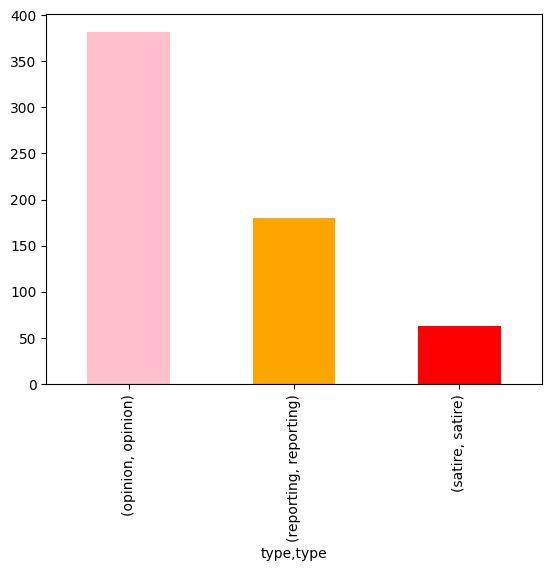

In [9]:
train_df.groupby('type').type.value_counts().plot(kind = "bar", color = ["pink", "orange", "red"])
plt.show()

In [19]:
def get_split(text1):
  len_t=250
  l_total = []
  l_parcial = []
  count=0
  if len(text1.split())//len_t >0:
    count += 1    
    n = len(text1.split())//len_t
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:len_t]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*len_t:w*len_t + len_t]
      l_total.append(" ".join(l_parcial))
  return l_total

splited=train_df['text'].apply(get_split).to_frame()

In [20]:
splited=train_df['text'].apply(get_split).to_frame()

In [21]:
train_df['text_splited']=splited['text']

In [22]:
train_df['split']=train_df['text_splited'].str.len()
train_df['article_id'] = train_df.index
train_df

,text,type,text_trunc,text_splited,split,article_id
id,,,,,,
833042063,chelsea handler admits shes very sexually attr...,satire,chelsea handler admits shes very sexually attr...,[chelsea handler admits shes very sexually att...,1,833042063
832959523,how theresa may botched those were the times t...,satire,how theresa may botched those were the times t...,[how theresa may botched those were the times ...,3,832959523
833039623,robert mueller iii rests his case—dems never w...,satire,robert mueller iii rests his case—dems never w...,[robert mueller iii rests his case—dems never ...,4,833039623
833032367,robert mueller not recommending any more indic...,satire,robert mueller not recommending any more indic...,[robert mueller not recommending any more indi...,2,833032367
814777937,the far right is trying to co-opt the yellow v...,satire,the far right is trying to co-opt the yellow v...,[the far right is trying to co-opt the yellow ...,3,814777937
...,...,...,...,...,...,...
25181,side effects after novavax vaccine against cov...,reporting,side effects after novavax vaccine against cov...,[side effects after novavax vaccine against co...,1,25181
25164,the together party asks the government about t...,reporting,the together party asks the government about t...,[the together party asks the government about ...,1,25164
25187,president andrzej duda signed the act on the c...,reporting,president andrzej duda signed the act on the c...,[president andrzej duda signed the act on the ...,1,25187


In [23]:
df1 = train_df#[train_df['type']!='opinion']
for index,row in df1.iterrows():
    for w in range(row['split']):
            row['text']=row['text_splited'][w]
            train_df= pd.concat([train_df, row.to_frame().T], axis=0, ignore_index=True)

In [24]:
len(train_df[train_df['type']=='satire'])

157

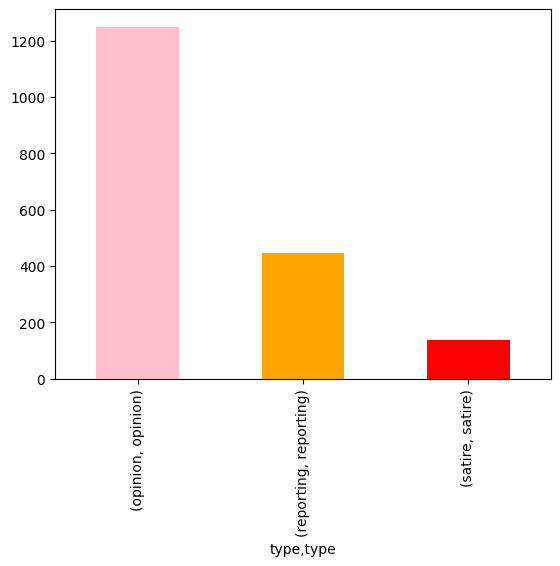

In [58]:
train_df.groupby('type').type.value_counts().plot(kind = "bar", color = ["pink", "orange", "red"])
plt.show()

In [60]:
def balance_pandas(data):
    lst = [data]
    max_size = data['type'].value_counts().max()
    for class_index, group in data.groupby('type'):
        lst.append(group.sample(max_size - len(group), replace=True))
    return pd.concat(lst)
train_df = balance_pandas(train_df)

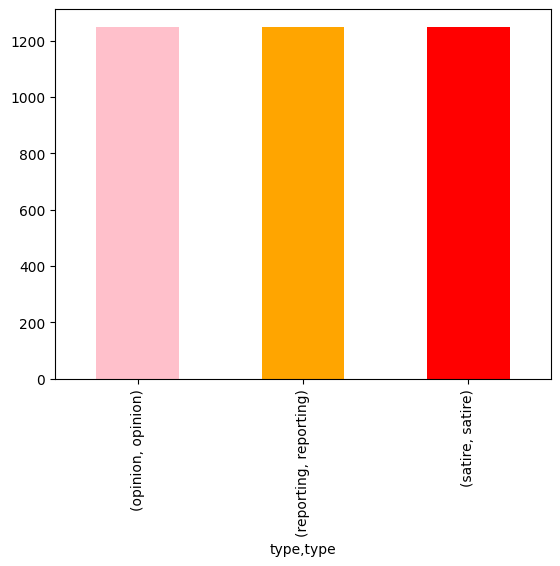

In [61]:
train_df.groupby('type').type.value_counts().plot(kind = "bar", color = ["pink", "orange", "red"])
plt.show()

In [15]:
'''
opi=train_df[train_df['type']=='opinion']
opi=opi.sample(frac=0.5)
rest=train_df[train_df['type']!='opinion']
train_df=rest.append(opi)
'''

/tmp/ipykernel_390909/2111642924.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df=rest.append(opi)


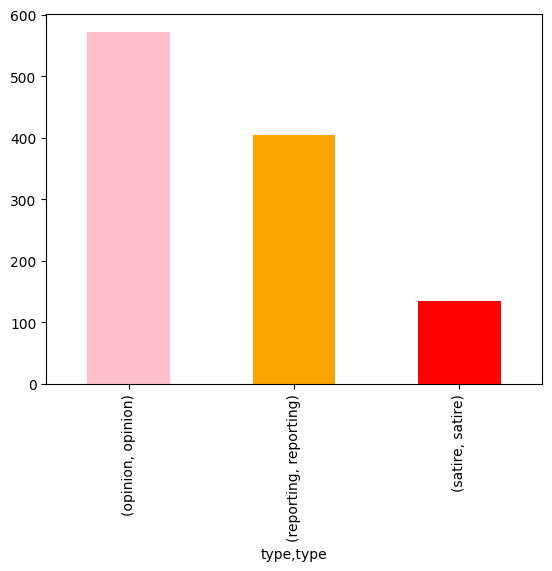

In [16]:
train_df.groupby('type').type.value_counts().plot(kind = "bar", color = ["pink", "orange", "red"])
plt.show()

In [94]:
# Global vars - vars in ALL_CAPS can be adjusted to enable experiments

#Dataset vars
THESE_LABELS = "type" # use 'label' for multi-class classification & 'label_binary' for binary
NUM_LABELS = train_df[THESE_LABELS].nunique()
print(f"NUM_LABELS: {NUM_LABELS}")

#BERT/Training vars
MODEL = "distilbert-base-cased"
#MODEL = "distilbert-base-multilingual-uncased"
#MODEL = "roberta-base"
EPOCHS = 5 # Good starting range is 2 to 4
LEARNING_RATE = 6e-5 # Good starting range is 2e-5 to 5e-5
BATCH_SIZE = 32 # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

NUM_LABELS: 3


In [95]:
sentences = train_df.text.values

le = LabelEncoder()
labels = le.fit_transform(train_df[THESE_LABELS]) # encode labels as ints

counter = 0
for entry in le.classes_:
  print(f"{counter}: {entry}")
  counter += 1

train_df[THESE_LABELS+"_encoded"] = labels # add col to train_df with ints for labels

0: opinion
1: reporting
2: satire


In [96]:
print('Loading tokenizer...')
if MODEL == "distilbert-base-cased":

  from transformers import DistilBertTokenizer
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', do_lower_case = True)

elif MODEL == "distilbert-base-uncased":

  from transformers import DistilBertTokenizer
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case = True)

elif MODEL == "distilbert-base-multilingual-uncased":

  from transformers import DistilBertTokenizer
  tokenizer = DistilBertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case = True)

elif MODEL == "bert-base-cased":

  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

elif MODEL == "roberta-base":

  from transformers import RobertaTokenizer
  tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

else:
  raise ValueError('Unknown model specified. Check MODEL var.')

Loading tokenizer...


In [97]:
random_sample = random.randint(0,train_df.shape[0])

# Print the original sentence.
print(' Original: ', sentences[random_sample])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[random_sample]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[random_sample])))

#Print the associated label
print("Label: ", labels[random_sample])

 Original:  able to handle millions of people since obama planned to have over a million muslim refugees brought into the us over a short period of time along with the hundreds of thousands of illegal immigrants coming in one can understand the reason the feds had to have the walmart stores and so much land as they needed housing for the millions they planned to bring in despite president trump signing an executive order suspending syrian refugees from entering the us for 120 days on jan 26 2017 while security measures were reviewed the us still imported 110000 refugees from syria and various other countries into the us in 2017 alone up from 85000 the previous year these numbers follow obama 's projections of the expected amount of refugees permitted to come to the us of course as with the number of illegal immigrants entering our county the feds downplay the actual number which always ends up to be more than quadruple their stated number what we seem to have here with the illegal immi

In [98]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

if max_len <= 512:
  print('Max sentence length: ', max_len) #max sentence len for BERT is 512
else:
  warnings.warn("WARNING: max_len exceeds max token length for BERT.")

Token indices sequence length is longer than the specified maximum sequence length for this model (1063 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
train_df[train_df['type']=='opinion']['text'].str.len().hist()

In [110]:
input_ids[random_sample]

tensor([  101,  1682,  1106,  4282,  9215,  1104,  1234,  1290,   184,  2822,
         1918,  2919,  1106,  1138,  1166,   170,  1550,   182,  1361, 24891,
         8940,  1814,  1154,  1103,  1366,  1166,   170,  1603,  1669,  1104,
         1159,  1373,  1114,  1103,  5229,  1104,  4674,  1104,  5696,  7162,
         1909,  1107,  1141,  1169,  2437,  1103,  2255,  1103,  7672,  1116,
         1125,  1106,  1138,  1103, 20049, 16882,  3740,  4822,  1105,  1177,
         1277,  1657,  1112,  1152,  1834,  3328,  1111,  1103,  9215,  1152,
         2919,  1106,  2498,  1107,  2693,  2084,   189, 27321,  6086,  1126,
         3275,  1546, 28117, 20080, 16264,   188, 21149,  8940,  1121,  5273,
         1103,  1366,  1111,  5356,  1552,  1113,   179,  1389,  1744,  1504,
         1229,  2699,  5252,  1127,  7815,  1103,  1366,  1253, 11095, 24450,
         7629,  8940,  1121,   188, 12577,  1465,  1105,  1672,  1168,  2182,
         1154,  1103,  1366,  1107,  1504,  2041,  1146,  1121, 

In [101]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    #`encode_plus` will:
    #(1) Tokenize the sentence.
    #(2) Prepend the `[CLS]` token to the start.
    #(3) Append the `[SEP]` token to the end.
    #(4) Map tokens to their IDs.
    #(5) Pad or truncate the sentence to `max_length`
    #(6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        sent,                         #Sentence to encode.
        add_special_tokens=True,    #Add '[CLS]' and '[SEP]'
        max_length=512,         #Pad & truncate all sentences.
        truncation=True,
        pad_to_max_length=True,
        return_attention_mask=True, # Construct attn. masks.
        return_tensors='pt',        # Return pytorch tensors.
        
    )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence as a list of IDs.
print('Original: ', sentences[random_sample])
print('Token IDs:', input_ids[random_sample])
print('attention_masks:', len(attention_masks[random_sample]))

tot1=sum(i > 0 for i in input_ids[random_sample])
tot2=sum(i > 0 for i in attention_masks[random_sample])
#print(tot1,tot2)
encoded_dict['token_type_ids']

Original:  able to handle millions of people since obama planned to have over a million muslim refugees brought into the us over a short period of time along with the hundreds of thousands of illegal immigrants coming in one can understand the reason the feds had to have the walmart stores and so much land as they needed housing for the millions they planned to bring in despite president trump signing an executive order suspending syrian refugees from entering the us for 120 days on jan 26 2017 while security measures were reviewed the us still imported 110000 refugees from syria and various other countries into the us in 2017 alone up from 85000 the previous year these numbers follow obama 's projections of the expected amount of refugees permitted to come to the us of course as with the number of illegal immigrants entering our county the feds downplay the actual number which always ends up to be more than quadruple their stated number what we seem to have here with the illegal immig

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [109]:
encoded_dict

{'input_ids': tensor([[  101, 26006, 11098,  5895, 12500,   129,   110,  1104,  1103,   185,
         25694,  1324,  1416,  1107,   192, 26524,   118,  1743,   110,  1780,
          1103,  1295,  1104, 26006, 11098,  5895,  1107,   185,  5326,  3276,
          2204,  1106,  3081,  1559,  1550,  1107,  1336,  1152,  1253, 12500,
           129,  3029,  1103,  1416,  1104,  1103,  1583,   118,   173, 15039,
          9238,  4847,  2806,  1777,   185, 28115,  1605,  1163,  1113, 19863,
          6194,   173,  1403,  1643,  2752,  1106,  1103,  2686,  1104,  1103,
          6270,  2592,  4156,  1118,  1103,  3779,  1104,  1103,   185, 25694,
          1324, 16411, 14386, 15276,  1643,  1126,  2369,  1104,  1367,  2026,
          3038,  1104,  1103,  1583,  2233,  1359,  1113,  1103,  3622,  1104,
          1869,  1121,  6866, 16215,  1105,  1103,   185,  6420,  1233,  1295,
          8077,  2190,  1104,  2849,  3836,  1118, 26006, 11098,  5895,  1121,
          1103,   187, 13356,  1811,  

In [107]:

(attention_masks[random_sample] - input_ids[random_sample]).sum().float()

tensor(-991899.)

In [68]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,372 training samples
  375 validation samples


In [69]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

In [70]:
if MODEL == "distilbert-base-cased":

  from transformers import DistilBertForSequenceClassification

  model = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-cased",
      num_labels = NUM_LABELS,
      output_attentions = False,
      output_hidden_states = False,
)#.cuda()
  
elif MODEL == "distilbert-base-uncased":

  from transformers import DistilBertForSequenceClassification

  model = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-uncased",
      num_labels = NUM_LABELS,
      output_attentions = False,
      output_hidden_states = False,
)
    
elif MODEL == "distilbert-base-multilingual-uncased":

  from transformers import DistilBertForSequenceClassification

  model = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-multilingual-cased",
      num_labels = NUM_LABELS,
      output_attentions = False,
      output_hidden_states = False,
)
  
elif MODEL == "bert-base-cased":

  from transformers import BertForSequenceClassification

  model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = NUM_LABELS,
    output_attentions = False,
    output_hidden_states = False,
)
  
elif MODEL == "roberta-base":

  from transformers import RobertaForSequenceClassification

  model = RobertaForSequenceClassification.from_pretrained('roberta-base',num_labels = NUM_LABELS,
    output_attentions = False,
    output_hidden_states = False,)

else:
  raise ValueError('Unknown model specified. Check MODEL var.')



Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weigh

In [71]:
optimizer = AdamW(
    model.parameters(),
    lr = LEARNING_RATE,
    eps = 1e-8 #small weight to add to avoid zero weights
)

/home/osservatorio/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [72]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps
)

In [73]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
def val_metrics(preds, labels):
  """
  Calculates a variety of metrics during validation steps in training.

  Args:
    preds - an array of prediction scores, one for each class being assessed. Will be an array of shape (n_samples,1).
    labels - an array of the true labels for a given set of validation samples. Should also be an array of shape (n_samples, n_classes). 

  Returns:
    result - a dictionary of metrics and their values.
  """
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  precision, recall, f1_micro, support = precision_recall_fscore_support(
      y_true = labels_flat, 
      y_pred = preds_flat, 
      zero_division = 0, 
      average = "micro"
  ) #using average = micro is consistent with LR & other models & SemEval metrics

  f1_macro = f1_score(y_true = labels_flat, y_pred = preds_flat, average = "macro", zero_division = 0)

  result = {
      "Precision": precision,
      "Recall": recall,
      "F1_micro": f1_micro,
      "F1_macro": f1_macro
  }

  return result
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [75]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Avg. Accur.,Avg. Precision,Avg. Recall,Avg. F1_micro,Avg. F1_macro,Training Time,Validation Time
epoch,,,,,,,,,
1,0.436385,0.164985,0.934896,0.934896,0.934896,0.934896,0.935306,0:32:43,0:01:00
2,0.101839,0.092630,0.962523,0.962523,0.962523,0.962523,0.962741,0:31:25,0:00:58
3,0.027467,0.049244,0.986979,0.986979,0.986979,0.986979,0.986370,0:31:38,0:00:58


In [76]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.4363850849627886,
  'Valid. Loss': 0.1649850153674682,
  'Avg. Accur.': 0.9348958333333334,
  'Avg. Precision': 0.9348958333333334,
  'Avg. Recall': 0.9348958333333334,
  'Avg. F1_micro': 0.9348958333333334,
  'Avg. F1_macro': 0.935306185152656,
  'Training Time': '0:32:43',
  'Validation Time': '0:01:00'},
 {'epoch': 2,
  'Training Loss': 0.10183905822857511,
  'Valid. Loss': 0.09263018146157265,
  'Avg. Accur.': 0.9625226449275363,
  'Avg. Precision': 0.9625226449275363,
  'Avg. Recall': 0.9625226449275363,
  'Avg. F1_micro': 0.9625226449275363,
  'Avg. F1_macro': 0.962740686430791,
  'Training Time': '0:31:25',
  'Validation Time': '0:00:58'},
 {'epoch': 3,
  'Training Loss': 0.02746656674997143,
  'Valid. Loss': 0.04924366362683941,
  'Avg. Accur.': 0.9869791666666666,
  'Avg. Precision': 0.9869791666666666,
  'Avg. Recall': 0.9869791666666666,
  'Avg. F1_micro': 0.9869791666666666,
  'Avg. F1_macro': 0.9863701665547092,
  'Training Time': '0:31:3

In [77]:
df_stats.describe().loc["mean",["Avg. Accur.","Avg. Precision", "Avg. Recall", "Avg. F1_micro", "Avg. F1_macro"]]

Avg. Accur.       0.961466
Avg. Precision    0.961466
Avg. Recall       0.961466
Avg. F1_micro     0.961466
Avg. F1_macro     0.961472
Name: mean, dtype: float64

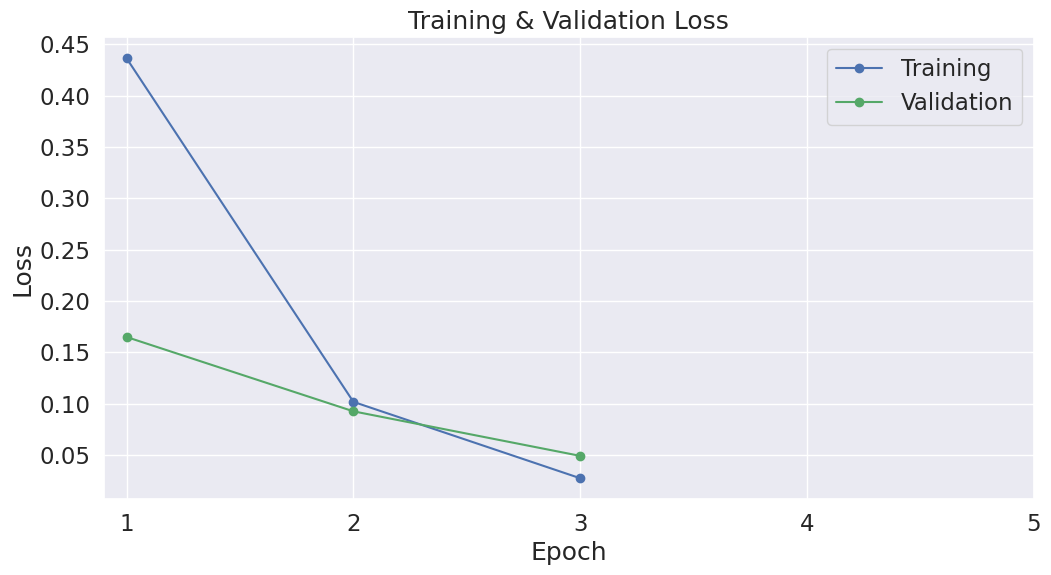

In [78]:
%matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1,EPOCHS+1))

plt.show()

In [79]:
output_dir = './multi_model_t1_trans_upsampling/'

# # Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.config.id2label = {i: le.classes_[i] for i in range(len(le.classes_))}
model_to_save.config.label2id = {le.classes_[i]:i for i in range(len(le.classes_))}
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./multi_model_t1_trans_upsampling/


('./multi_model_t1_trans_upsampling/tokenizer_config.json',
 './multi_model_t1_trans_upsampling/special_tokens_map.json',
 './multi_model_t1_trans_upsampling/vocab.txt',
 './multi_model_t1_trans_upsampling/added_tokens.json')

In [53]:
###DEV

In [80]:
label2id = model.config.label2id # these are the labels the model already "knows"

if len(label2id.items())>2:
    THESE_LABELS = 'label'
else:
    THESE_LABELS = 'label_binary'

label2id

{'opinion': 0, 'reporting': 1, 'satire': 2}

In [81]:
# Load the dataset into a pandas dataframe.
dev_df = pd.read_csv(
    "data/en/dev_data_1.tsv",
    sep = "\t",
    header = 0,
    index_col = 0
) 

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(dev_df.shape[0]))

#dev_df["label_encoded"] = dev_df[THESE_LABELS].map(label2id) # use same mapping from model

sentences = dev_df.text.values

Number of test sentences: 83



In [82]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_dataloader = DataLoader(prediction_data, batch_size = BATCH_SIZE)

/home/osservatorio/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [83]:
# Prediction on test set

print('Predicting labels for {:,} dev sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch

  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

Predicting labels for 83 dev sentences...
    DONE.


In [84]:
#Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis = 0)

predicted_probs = softmax(flat_predictions)

dev_df["predicted_label"] = np.argmax(predicted_probs, axis = 1) #Find the index of highest predicted probability, this is the predicted 

In [85]:
label2id

{'opinion': 0, 'reporting': 1, 'satire': 2}

In [86]:
id2label = {y: x for x, y in label2id.items()}
id2label

{0: 'opinion', 1: 'reporting', 2: 'satire'}

In [87]:
df2=dev_df.replace({"predicted_label": id2label})
print(df2)

                                                        text predicted_label
id                                                                          
832926076  Trump and Melania beam as they pose for photos...         opinion
814251296  UK Govt to Perform No Deal Brexit Dress Rehear...       reporting
832971448  Jokes and memes about Robert Mueller's investi...          satire
822220578  UK Labour Leader Corbyn Losing Support Over Fa...          satire
832947852  Top 10 Propagandists Who Pushed Russia Collusi...       reporting
...                                                      ...             ...
830153674  Britain’s Attorney General Deals Blow to May’s...          satire
824684605  Seven U.K. Labour Lawmakers Quit Over Jeremy C...          satire
833053628  Confident Trump and anxious Washington wait fo...         opinion
830359136  The Fight for Brexit\n\nTo see how serious the...          satire
813552066  You insult us, ambassador: Woody Johnson flagr...         opinion

In [88]:
#dev_df['article_id'] = dev_df.index
dev_output=df2[['predicted_label']]

In [89]:
dev_output.to_csv("outputs/en/dev_1_trans_upsampling.txt", sep = "\t", header = True)

In [ ]:
#python3 st1.py -o ../outputs/en/dev_1.txt ../data/it/train-articles-subtask-1/ ../data/it/dev-articles-subtask-1/ ../data/it/train-labels-subtask-1.txt 